# mr-ash example analysis
Here we analyze [GTEx based simulation data](MR-ASH-Simulation.html) using mr-ash implemented  in `varbvs`. The simulated data is stored in the same format as the [processed GTEx](../pipeline/Pipelines.html#Preprocessing) data; therefore the same procedure can be used directly for data analysis. The only difference is that simulated data do not have covariates.

All files are saved in HDF5 format on midway `project/compbio/internal_public_supp/GTEx7Toy`. In the toy data-set I selected 3 genes:

```
/chr4/ENSG00000145214
/chr18/ENSG00000264247
/chr19/ENSG00000267508
```
These should be used as `geno_table` variable in the code below. 

For the toy real data there are 53 groups in the HDF file. Their names are available via:

```bash
h5ls TY.expr.h5 
```
For the simulated data there is only one group called `simulated`, which is the data I'll use in the example below.

To load data:

In [1]:
# source("http://bioconductor.org/biocLite.R")
# biocLite("rhdf5")
library(rhdf5)
fpath = '/home/gaow/Documents/GTEx/ToyExample'
genotype_file = paste0(fpath, '/TY.genotype.h5')
expr_file = paste0(fpath, '/TY.expr_simulated.h5')
gene = 'ENSG00000145214'
geno_table = '/chr4/ENSG00000145214'
expr_table = '/simulated'

load_data = function(genotype_file, expr_file, geno_table, expr_table) {
    geno <- h5read(genotype_file, geno_table)
    gdata = geno$block0_values
    colnames(gdata) = geno$axis1
    rownames(gdata) = geno$axis0
    expr <- h5read(expr_file, expr_table)
    edata = expr$block0_values
    colnames(edata) = tools::file_path_sans_ext(expr$axis1)
    rownames(edata) = apply(sapply(strsplit(expr$axis0, "-"), `[`, c(1,2)), 2, function(x) paste(x, collapse = '-'))
    edata = edata[, basename(geno_table)]
    return(list(X=gdata,y=edata))
}

autoselect.mixsd = function(betahat,sebetahat,mult = sqrt(2)){
  sebetahat=sebetahat[sebetahat!=0] #To avoid exact measure causing (usually by mistake)
  sigmaamin = min(sebetahat)/10 #so that the minimum is small compared with measurement precision
  if(all(betahat^2<=sebetahat^2)){
    sigmaamax = 8*sigmaamin #to deal with the occassional odd case where this could happen; 8 is arbitrary
  }else{
    sigmaamax = 2*sqrt(max(betahat^2-sebetahat^2)) #this computes a rough largest value you'd want to use, based on idea that sigmaamax^2 + sebetahat^2 should be at least betahat^2   
  }
  if(mult==0){
    return(c(0,sigmaamax/2))
  }else{
    npoint = ceiling(log2(sigmaamax/sigmaamin)/log2(mult))
    return(mult^((-npoint):0) * sigmaamax)
  }
}


initial_step = function(X,y){
  P = dim(X)[2]
  output = matrix(0,nrow = P,ncol = 2)
  for(i in 1:P){
    # print(i)
    g = summary(lm(y~X[,i]))
    output[i,] = g$coefficients[2,1:2]
  }
  return(list(betahat = output[,1],sebetahat = output[,2]))
}
                            
dat = load_data(genotype_file, expr_file, geno_table, expr_table)

To analyze:

In [2]:
# library(devtools)
# install_github("pcarbo/varbvs",subdir = "varbvs-R")
X = as.matrix(dat$X)
storage.mode(X) <- "double"
y = as.vector(dat$y)
# Univariate analysis
initial = initial_step(X,y)

In [3]:
mixsd = autoselect.mixsd(initial$betahat,initial$sebetahat)
res = varbvs::varbvsmix(X, NULL, y, sa = c(0, mixsd^2)) #, sigma = 1, update.sigma = F)

Fitting variational approximation for linear regression model with
mixture-of-normals priors.
samples:      635    mixture component sd's:    0.054..39
variables:    7258   fit mixture variances:     no
covariates:   0      fit mixture weights:       yes
mixture size: 21     fit residual var. (sigma): yes
intercept:    yes    convergence tolerance      1.0e-04
       variational    max. --------- hyperparameters ---------
iter   lower bound  change   sigma  mixture sd's  mix. weights
 


To extract results from analysis:

In [4]:
# res$pip = res$alpha %*% c(res$w)
res$beta = rowSums(res$alpha * res$mu)
res$sigma
res$w

[1] 53.57896

[1] 9.312145e-01 6.359309e-02 1.842247e-03 7.458775e-06 1.114679e-07
 [6] 7.496910e-08 1.490017e-05 3.327604e-03 5.807216e-10 9.946424e-16
[11] 4.057255e-16 2.091955e-16 1.215463e-16 7.562610e-17 4.910190e-17
[16] 3.276519e-17 2.224117e-17 1.529654e-17 1.061580e-17 7.403526e-18
[21] 5.170231e-18

## Compare with simulation parameters

In [5]:
meta = paste0(fpath, '/TY.meta_simulation.json')
# install.packages('rjson', repos = 'http://cloud.r-project.org')
meta <- rjson::fromJSON(file = meta)
str(meta)

List of 4
 $ pi   : num [1:4] 0.4 0.2 0.2 0.2
 $ pi0  : num 0.8
 $ sigma: num [1:4] 0.25 0.5 1 2
 $ beta :List of 3
  ..$ ENSG00000264247: num [1:9871] -4.53 0 0 0 0 ...
  ..$ ENSG00000267508: num [1:8911] 3.803 0.336 0 0 0 ...
  ..$ ENSG00000145214: num [1:7258] -4.5178 0 0 -0.00039 0 ...


Compare mixture proportion estimates:


In [6]:
truth = c(meta$pi0, meta$pi * (1 - meta$pi0))
est = res$w
cbind(truth, est)

Warning message in cbind(truth, est):
“number of rows of result is not a multiple of vector length (arg 1)”

truth,est
0.80,9.312145e-01
0.08,6.359309e-02
0.04,1.842247e-03
0.04,7.458775e-06
0.04,1.114679e-07
0.80,7.496910e-08
0.08,1.490017e-05
0.04,3.327604e-03
0.04,5.807216e-10
0.04,9.946424e-16


Compare effect size estimates:

In [7]:
beta = cbind(res$beta, meta$beta[[gene]])
beta = beta[order(beta[,2]),]
beta

4:10253:G:T,-0.006961792,-4.517803
4:101562:G:A,-0.018006915,-4.154764
4:133427:G:A,-0.028940570,-4.102646
4:276765:A:T,-0.003503693,-3.664808
4:322080:A:G,-0.038514947,-3.338165
4:382491:C:T,0.002521938,-3.337780
4:516398:G:A,-0.034111523,-3.267727
4:525147:A:T,-0.012142610,-3.132209
4:572249:T:G,-0.018096343,-3.039982
4:783383:A:G,-0.015522899,-3.025803
4:1080533:G:A,-0.012591668,-2.713549


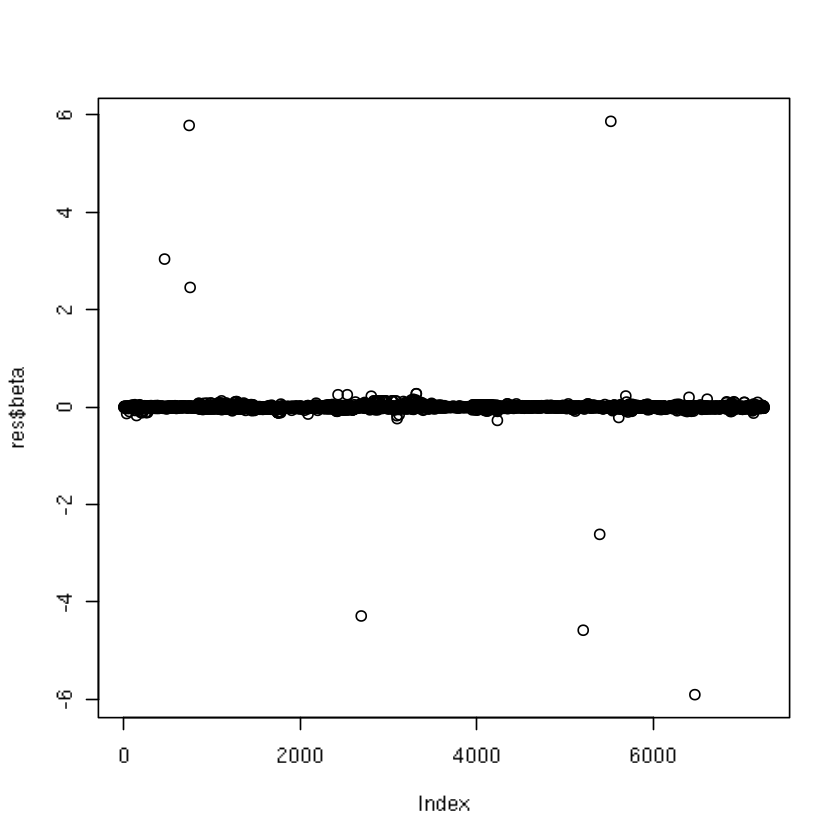

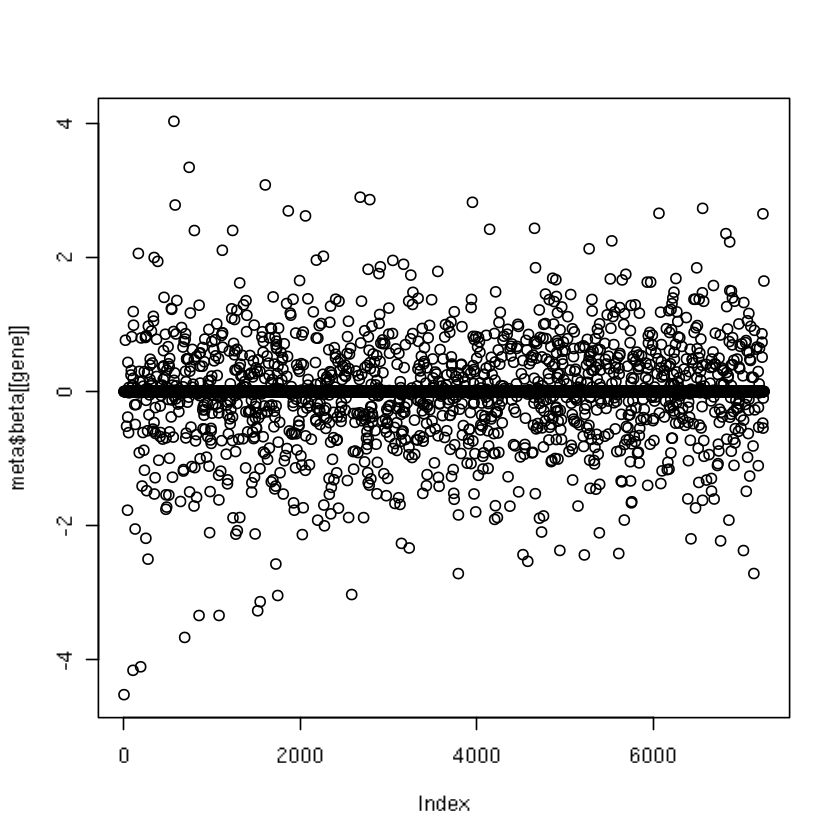

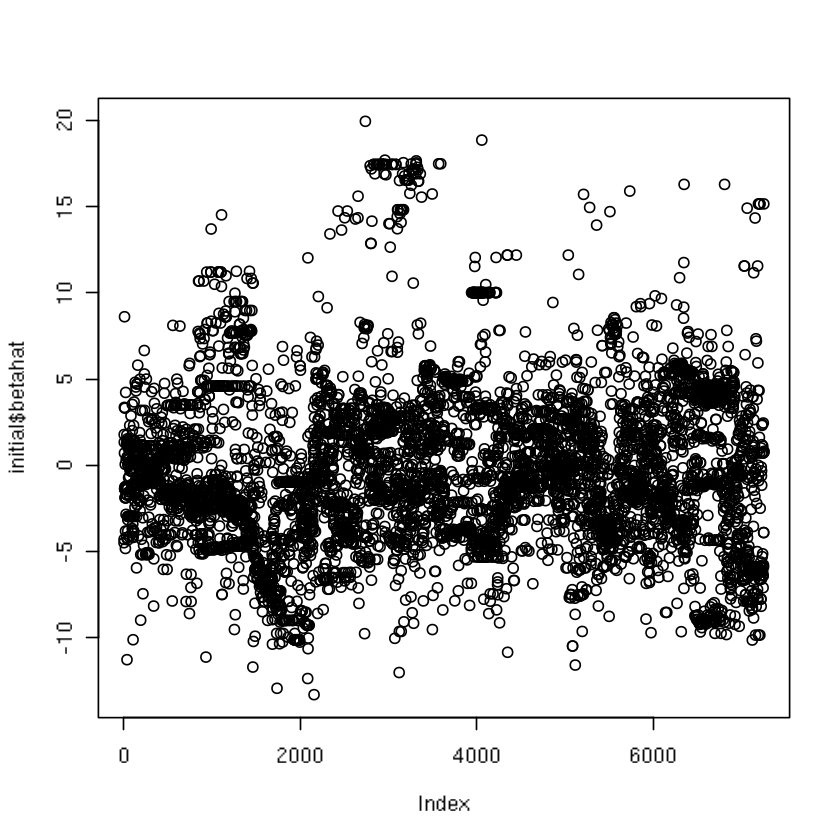

In [8]:
plot(res$beta)
plot(meta$beta[[gene]])
plot(initial$betahat)

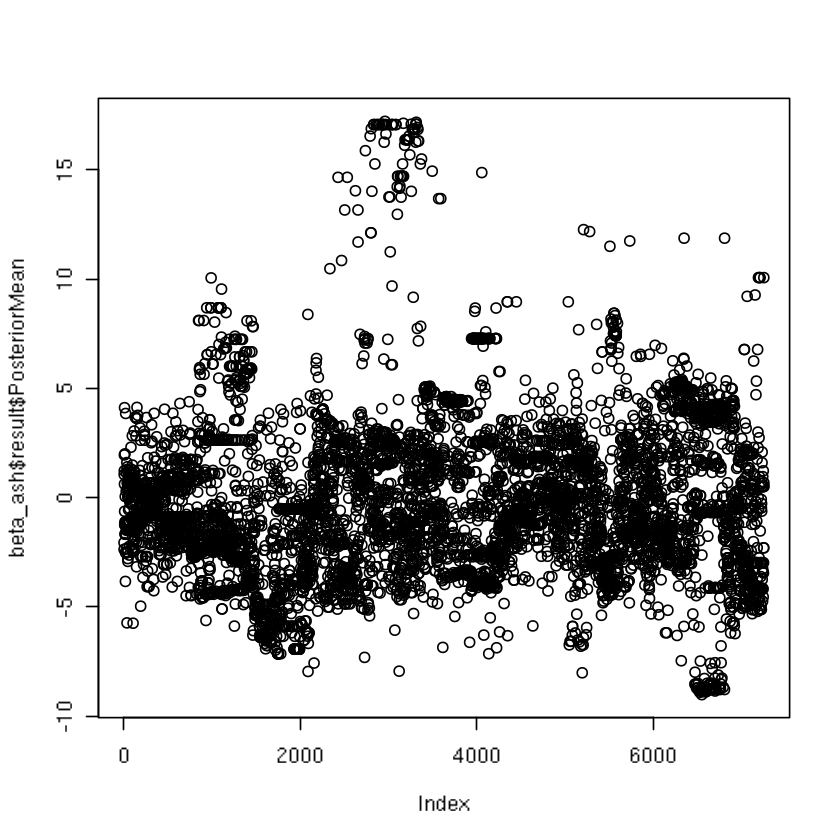

In [9]:
beta_ash = ashr::ash(initial$betahat,initial$sebetahat)
plot(beta_ash$result$PosteriorMean)

Warning message in plot(-log10(beta_ash$result$lfsr)):
“NaNs produced”

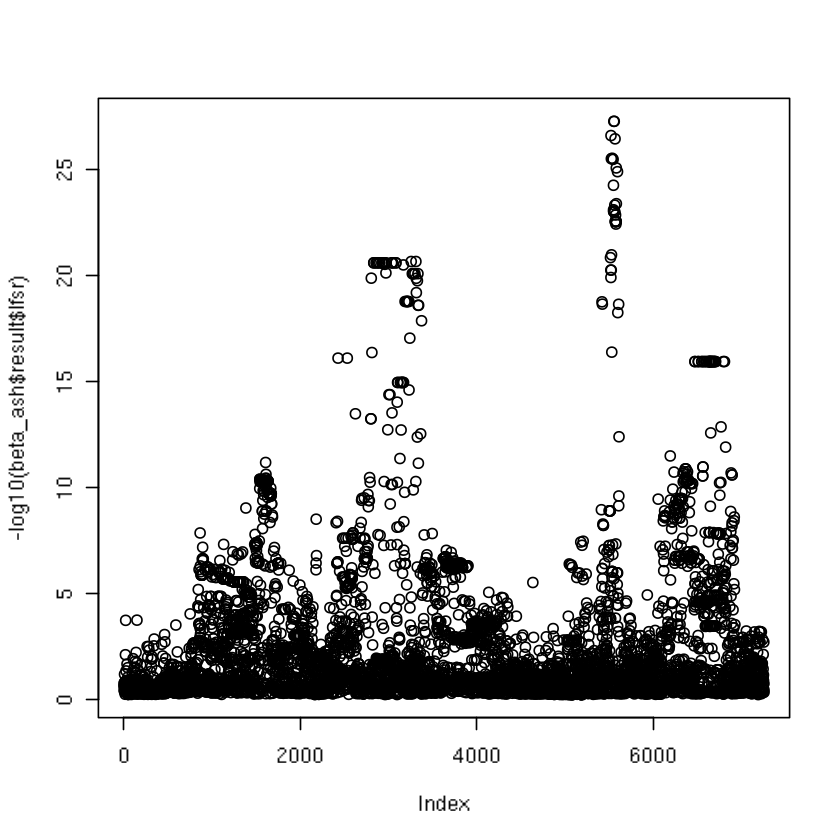

In [10]:
plot(-log10(beta_ash$result$lfsr))

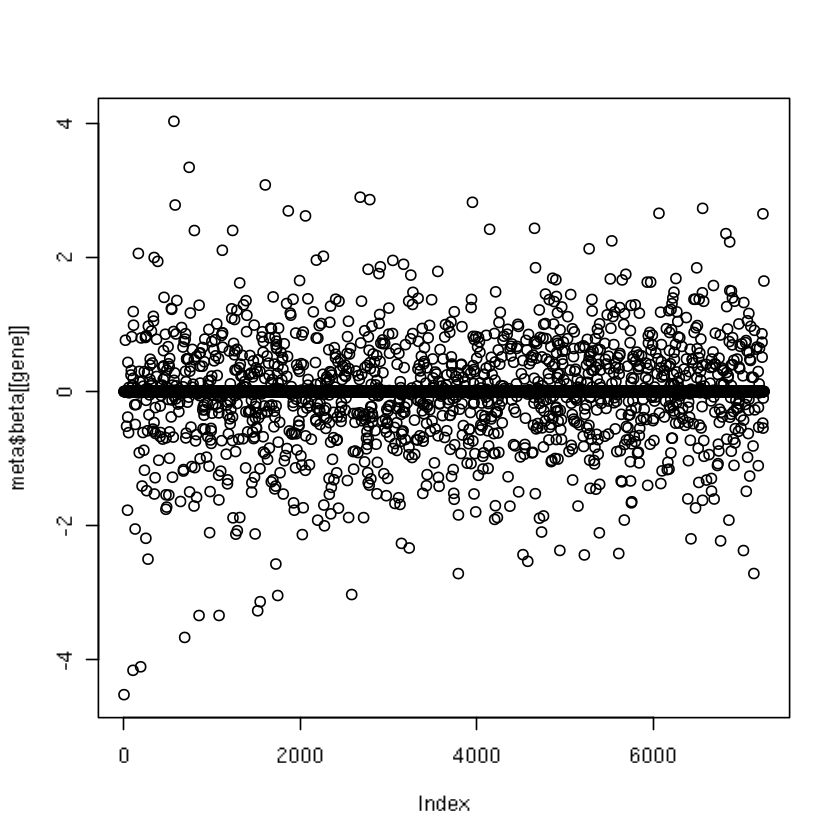

In [11]:
plot(meta$beta[[gene]])

0.912759


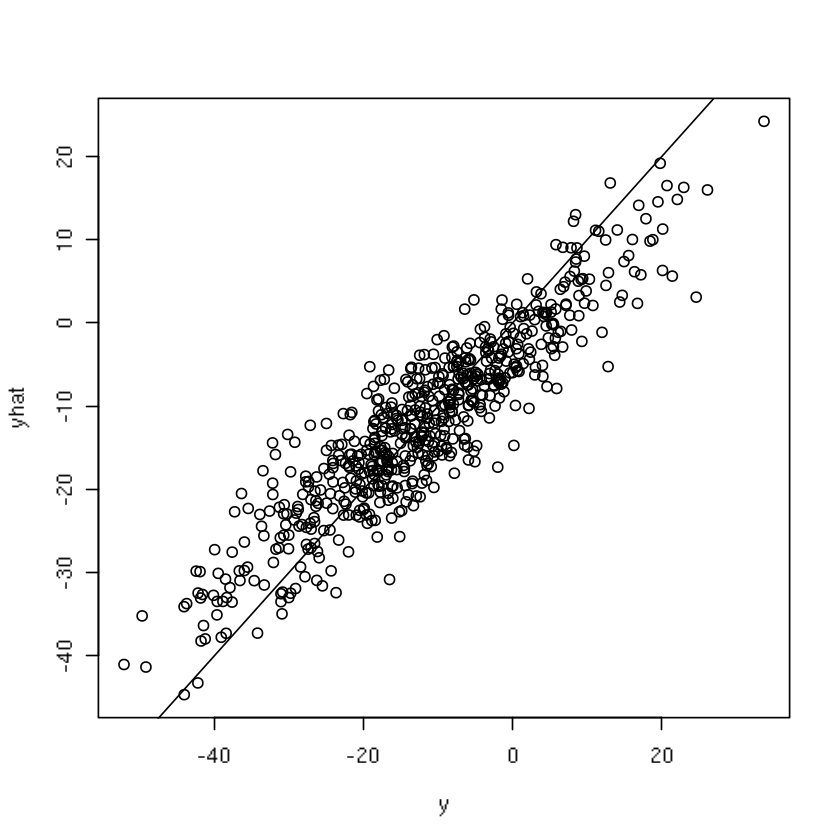

In [12]:
yhat = X %*% res$beta + res$mu.cov[1]
plot(y,yhat)
abline(0,1)
cor(y,yhat)

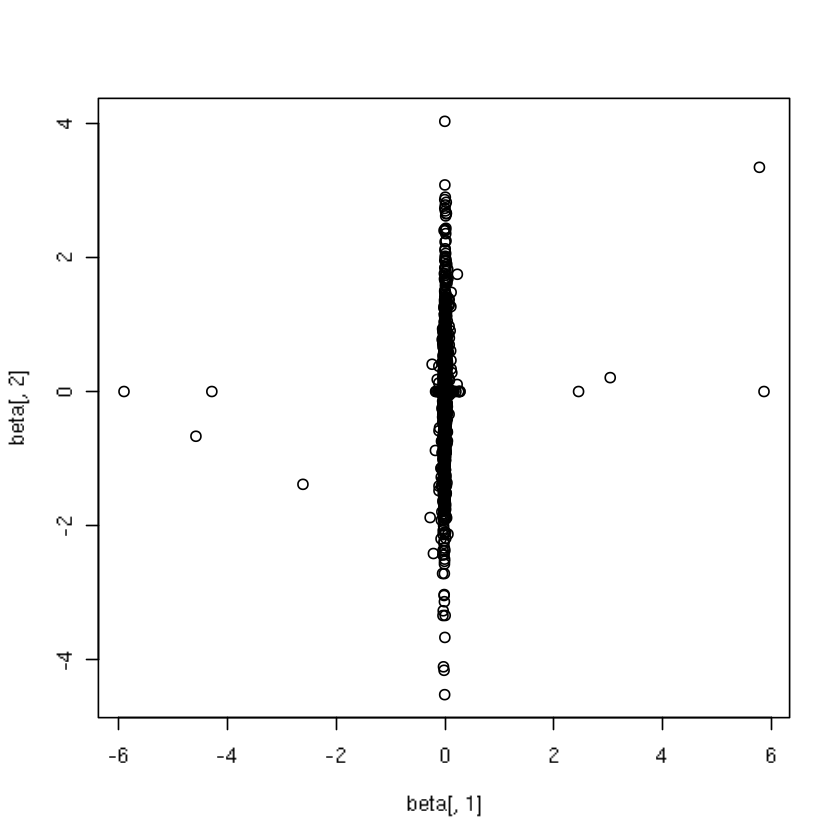

In [13]:
plot(beta[,1], beta[,2])